# Coauthorship graph
This is part II of the "Clustering of UGA Odum School of Ecology by Their Publications" project. You can find part I, in which I did Hierarchical clustering of the faculty [here](https://github.com/ArashSaeidpour/Hierarchical-Clustering-of-Odum-School-of-Ecology-Faculty-based-on-their-publications/blob/master/Clustering.ipynb). In this notebook, I am going to build a **Coauthorship graph**, which demonstrates the collaborations among different faculty members based on number of their coauthored publications. Each node of the graph represents a faculty member and edges corresponds to number of coahtored publications between two corresponding nodes. <br>

This was the project that I did to help strategic planing committee of the department to develop long-term and short-term hiring plans based on department's current research strengths and future aspirations.

# Data

I started off by scraping **titles** and **abstracts** of all the publications of each faculty. I used [Scholarly](https://pypi.org/project/scholarly/) to retrieve publication information for each faculty. Upon gathering titles and abstracts of all the publications, they were concatenated to form a `corpus` for the corresponding faculty member. You can find out more about my scraping procedure in [this notebook](https://link-to-scraping-notebook). In part I of this project I built the TF-IDF matrix from the publication corpora which I am going to use in this notebook to generate the "Coauthorship graph".

# Libraries
Let's make sure we have all the libraries that we need in our disposal first:

In [60]:
import numpy as np
import pandas as pd
from itertools import combinations,permutations,product
from os import path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import cm
import re
import networkx as nx
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram,fcluster
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from wordcloud import WordCloud
import nltk

In [12]:
eco_faculty=pd.read_pickle('Data/eco_faculty')
eco_faculty.index=eco_faculty.index.str.replace('.',' ')

In [13]:
tfidf_df=pd.read_pickle('tfidf_df.pickle')

In [56]:
infile=open('Faculty_to_cluster_number_dic.pickle','rb')
faculty_to_cluster_dic=pickle.load(infile)
infile.close()

In [57]:
infile=open('Cluster_to_faculty_dic.pickle','rb')
cluster_to_faculty_dic=pickle.load(infile)
infile.close()

In [14]:
non_gp_faculty=eco_faculty[eco_faculty.GS_link.isnull()].index

# Concatenating all publication in a dataframe

## Faculty with public Google scholar profile

In [15]:
dfs_dir='Faculty pubs w author names'
joint_df=pd.DataFrame()
for member in eco_faculty.index:
    if path.exists(dfs_dir+'/'+member):
        df_temp=pd.read_pickle(dfs_dir+'/'+member)
        df_temp['index_faculty']=member
        joint_df=pd.concat([joint_df,df_temp])

## Faculty w/o a public Google scholar profile

In [17]:
non_gp_dfs_dir='Faculty pubs'
for member in non_gp_faculty:
    df_temp=pd.read_pickle(non_gp_dfs_dir+'/'+member)
    df_temp['index_faculty']=member
    df_temp['authors']='-'
    for idx in df_temp.index:
        s=df_temp.loc[idx,'title']
        s=re.sub(r'\[.*\]','',s)
        s=re.sub(r'^\s','',s)
        s=re.sub(r'\\xa0...','',s)
        df_temp.loc[idx,'title']=s
    joint_df=pd.concat([joint_df,df_temp],sort='False')

# Removing dubplicate publication

In [18]:
unique_pubs=joint_df.title.unique()

In [20]:
non_gp_pubs=joint_df[joint_df.authors=='-']['title']

# Building adjacency matrix
I am going to build the adjacency matrix whose elements represents number of coauthored publications between any two faculty members. 

In [21]:
adj_matrix=pd.DataFrame(0,columns=eco_faculty.index,index=eco_faculty.index)

In [22]:
for pub in unique_pubs:
    co_auths=list(joint_df[joint_df.title==pub]['index_faculty'])
    for author in co_auths:
        adj_matrix.loc[author,author]+=1
    coauth_combs=combinations(co_auths,2)
    for comb in coauth_combs:
        adj_matrix.loc[comb[0],comb[1]]+=1
        adj_matrix.loc[comb[1],comb[0]]+=1

In [26]:
adj_matrix.index=['eco_faculty '+str(i+1) for i in range(adj_matrix.shape[0])]
adj_matrix.columns=['eco_faculty '+str(i+1) for i in range(adj_matrix.shape[1])]

## Adjacency matrix: Lower triangle plot

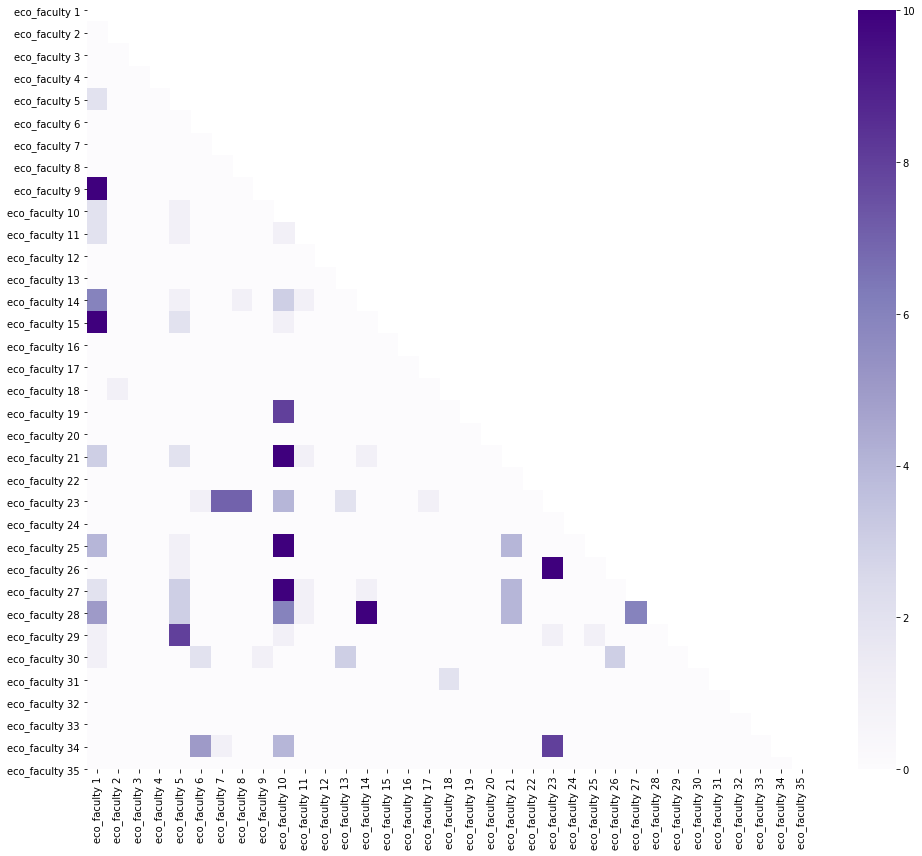

In [27]:
mask=np.zeros_like(adj_matrix,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(14,12))
sns.heatmap(adj_matrix,mask=mask,cmap='Purples',vmax=10)
plt.tight_layout()
#plt.savefig('adj matrix heatmap-lower triangle.png',dpi=300)
plt.show()

## Adjacency matrix: Full plot

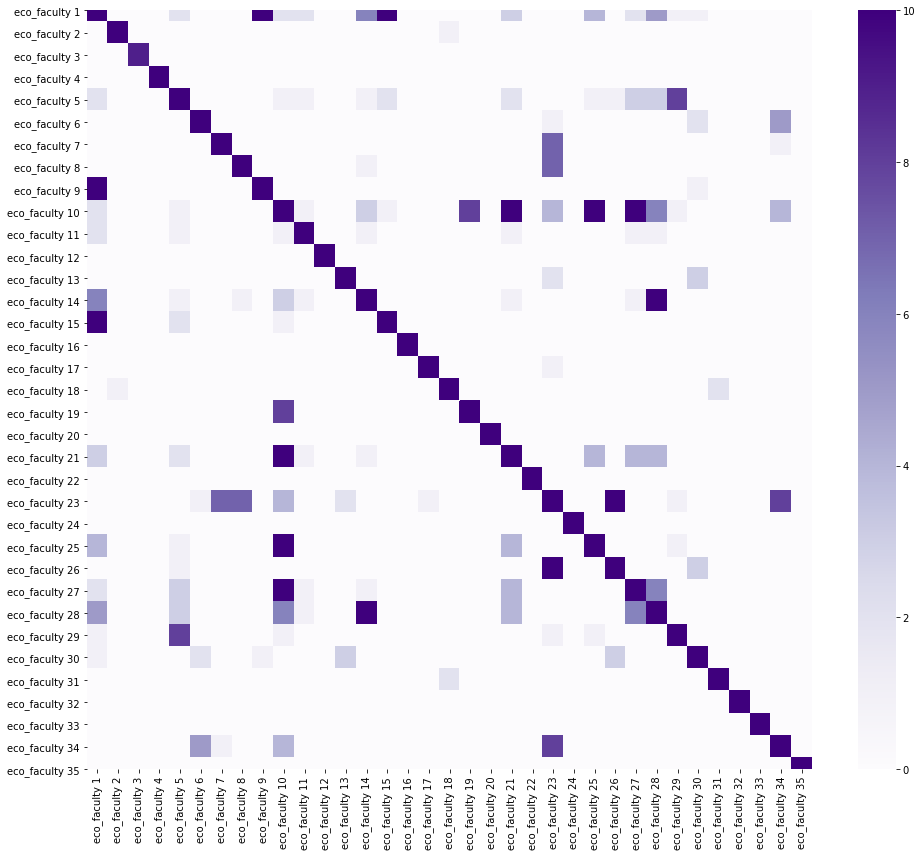

In [28]:
plt.figure(figsize=(14,12))
sns.heatmap(adj_matrix,cmap='Purples',vmax=10)
plt.tight_layout()
#plt.savefig('adj matrix heatmap-full matrix.png',dpi=300)
plt.show()

# Lexicographically ordered graph

## Adding nodes

In [29]:
G=nx.Graph()
G.add_nodes_from(adj_matrix.columns)

## Adding edges

In [31]:
for i in range(adj_matrix.shape[0]):
    for j in range(i):
        u=adj_matrix.index[i]
        v=adj_matrix.index[j]
        if adj_matrix.iloc[i,j]>0:
            G.add_edge(u,v,weight=adj_matrix.iloc[i,j])

# Cluster-based order graph

In [63]:
adj_matrix_sorted=pd.DataFrame(adj_matrix,
                               columns=sorted(faculty_to_cluster_dic,key=faculty_to_cluster_dic.get),
                               index=sorted(faculty_to_cluster_dic,key=faculty_to_cluster_dic.get) )

# Building the graph

## Adding nodes

In [64]:
G_sorted=nx.Graph()
G_sorted.add_nodes_from(adj_matrix_sorted.columns)

## Adding edges

In [65]:
for i in range(adj_matrix_sorted.shape[0]):
    for j in range(i):
        u=adj_matrix_sorted.index[i]
        v=adj_matrix_sorted.index[j]
        if adj_matrix_sorted.iloc[i,j]>0:
            G_sorted.add_edge(u,v,weight=adj_matrix_sorted.iloc[i,j])

# Graph visualization
Having calculated the adjacency matrix, now I can plot my coauthorship graph to see the relationship between various nodes (i.e. faculty members). I have made 4 different plots using [NetworkX library](https://networkx.github.io/) to demonstrate the graph:
1. Circular layout plot in alphabetical order,
2. Circular layout plot ordered by cluster number,
3. Principal Component Analysis (PCA)-projected plot,
4. Multidimensional scaling (MDS)-projected plot.
In the two latter plots coordinates of each node is determined by projecting the TF-IDF matrix onto 2D space. PCA and MDS are both dimensionality reduction techniques with different goals. PCA projects the data onto directions with the most variance while MDS attempts to preserve the pairwise distances of nodes as well as possible. 

## Alphabetical order - anonymized

In [78]:
cmap = cm.rainbow(np.linspace(0, 1, 5))
cluster_colors = {i:cmap[i-1][:3] for i in range(1,6)}

/home/arashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


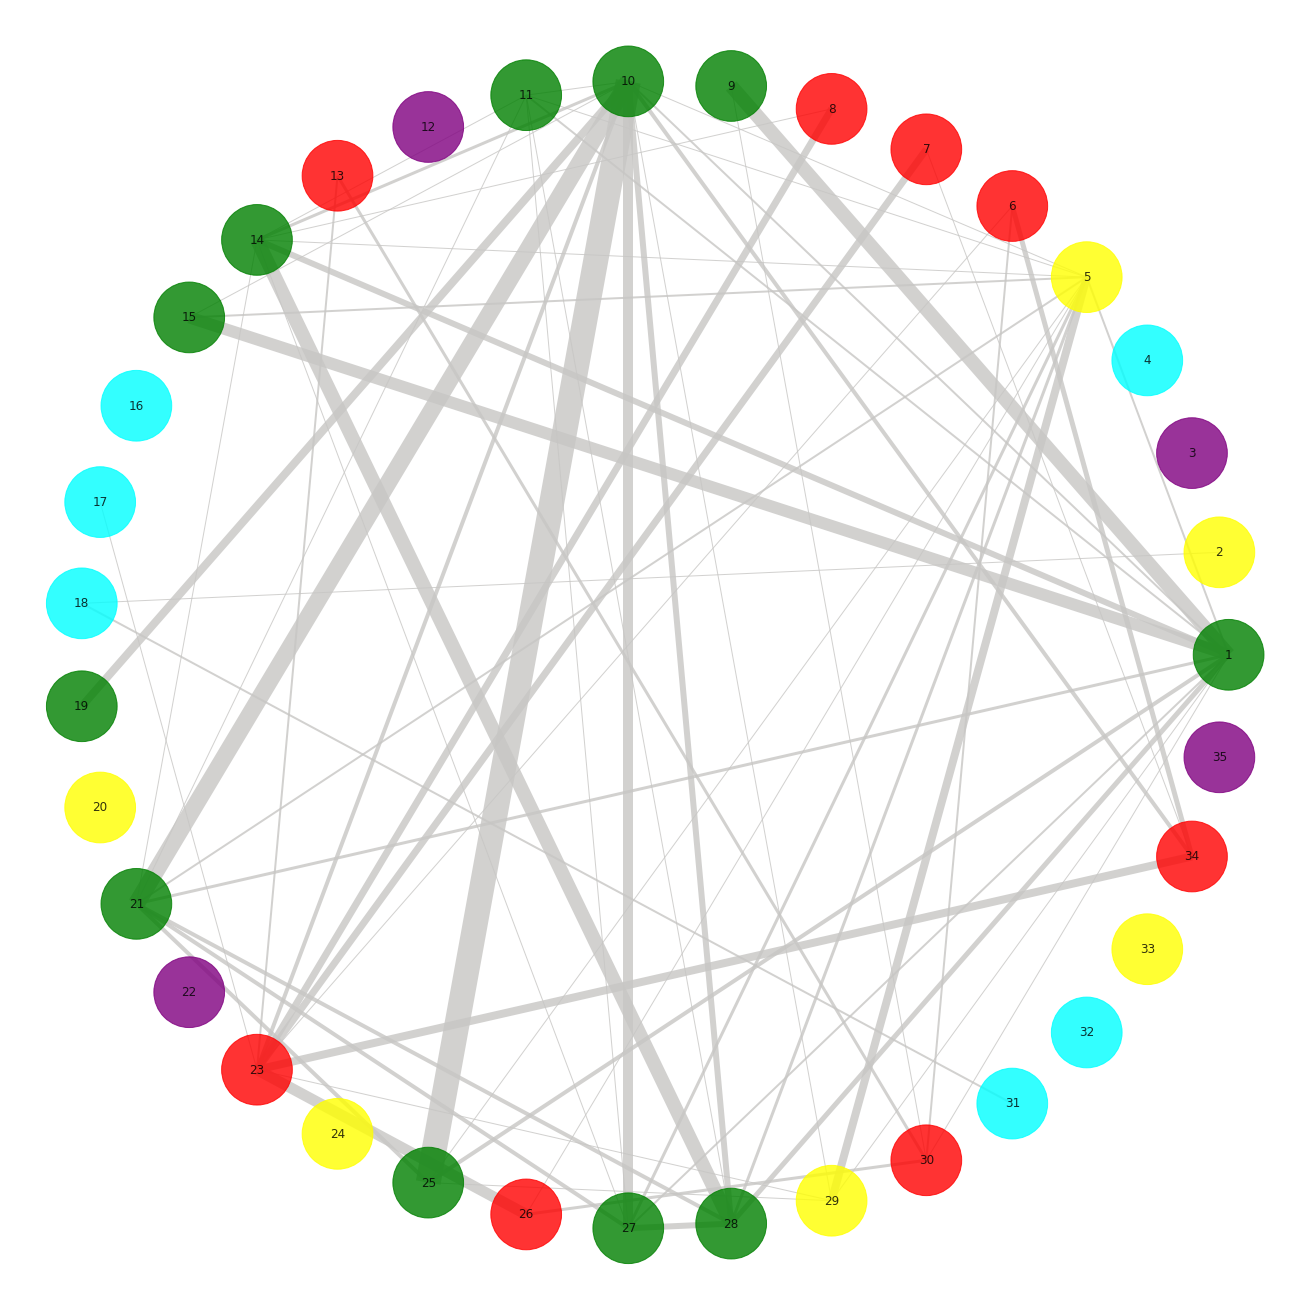

In [104]:
plt.figure(figsize=(18,18))
pos = nx.circular_layout(G)

edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]


colors_list=[]
for node in list(G.nodes):
    cluster_number=faculty_to_cluster_dic[node]
    colors_list.append(cluster_colors[cluster_number])

labels={name:list(name.split())[-1] for name in adj_matrix.index}

nx.draw(G,
        pos,
        node_color=colors_list,
        alpha=0.8,
        font_size=12,
        edge_color='#C7C6C4',
        edges=edges, 
        width=weights,
        labels=labels,
        with_labels=True,
        node_size=5000)

plt.show()

## Sorted by cluster - anonymized

In [67]:
stopwords = nltk.corpus.stopwords.words('english')
wordcloud_dic={}
for key in cluster_to_faculty_dic.keys():
    words_freq=tfidf_df.loc[cluster_to_faculty_dic[key],:].sum()
    wordcloud_dic[key]=WordCloud(stopwords=stopwords,width=1600, height=800,
                        background_color='white',normalize_plurals=True,
                        ).fit_words(words_freq)

/home/arashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


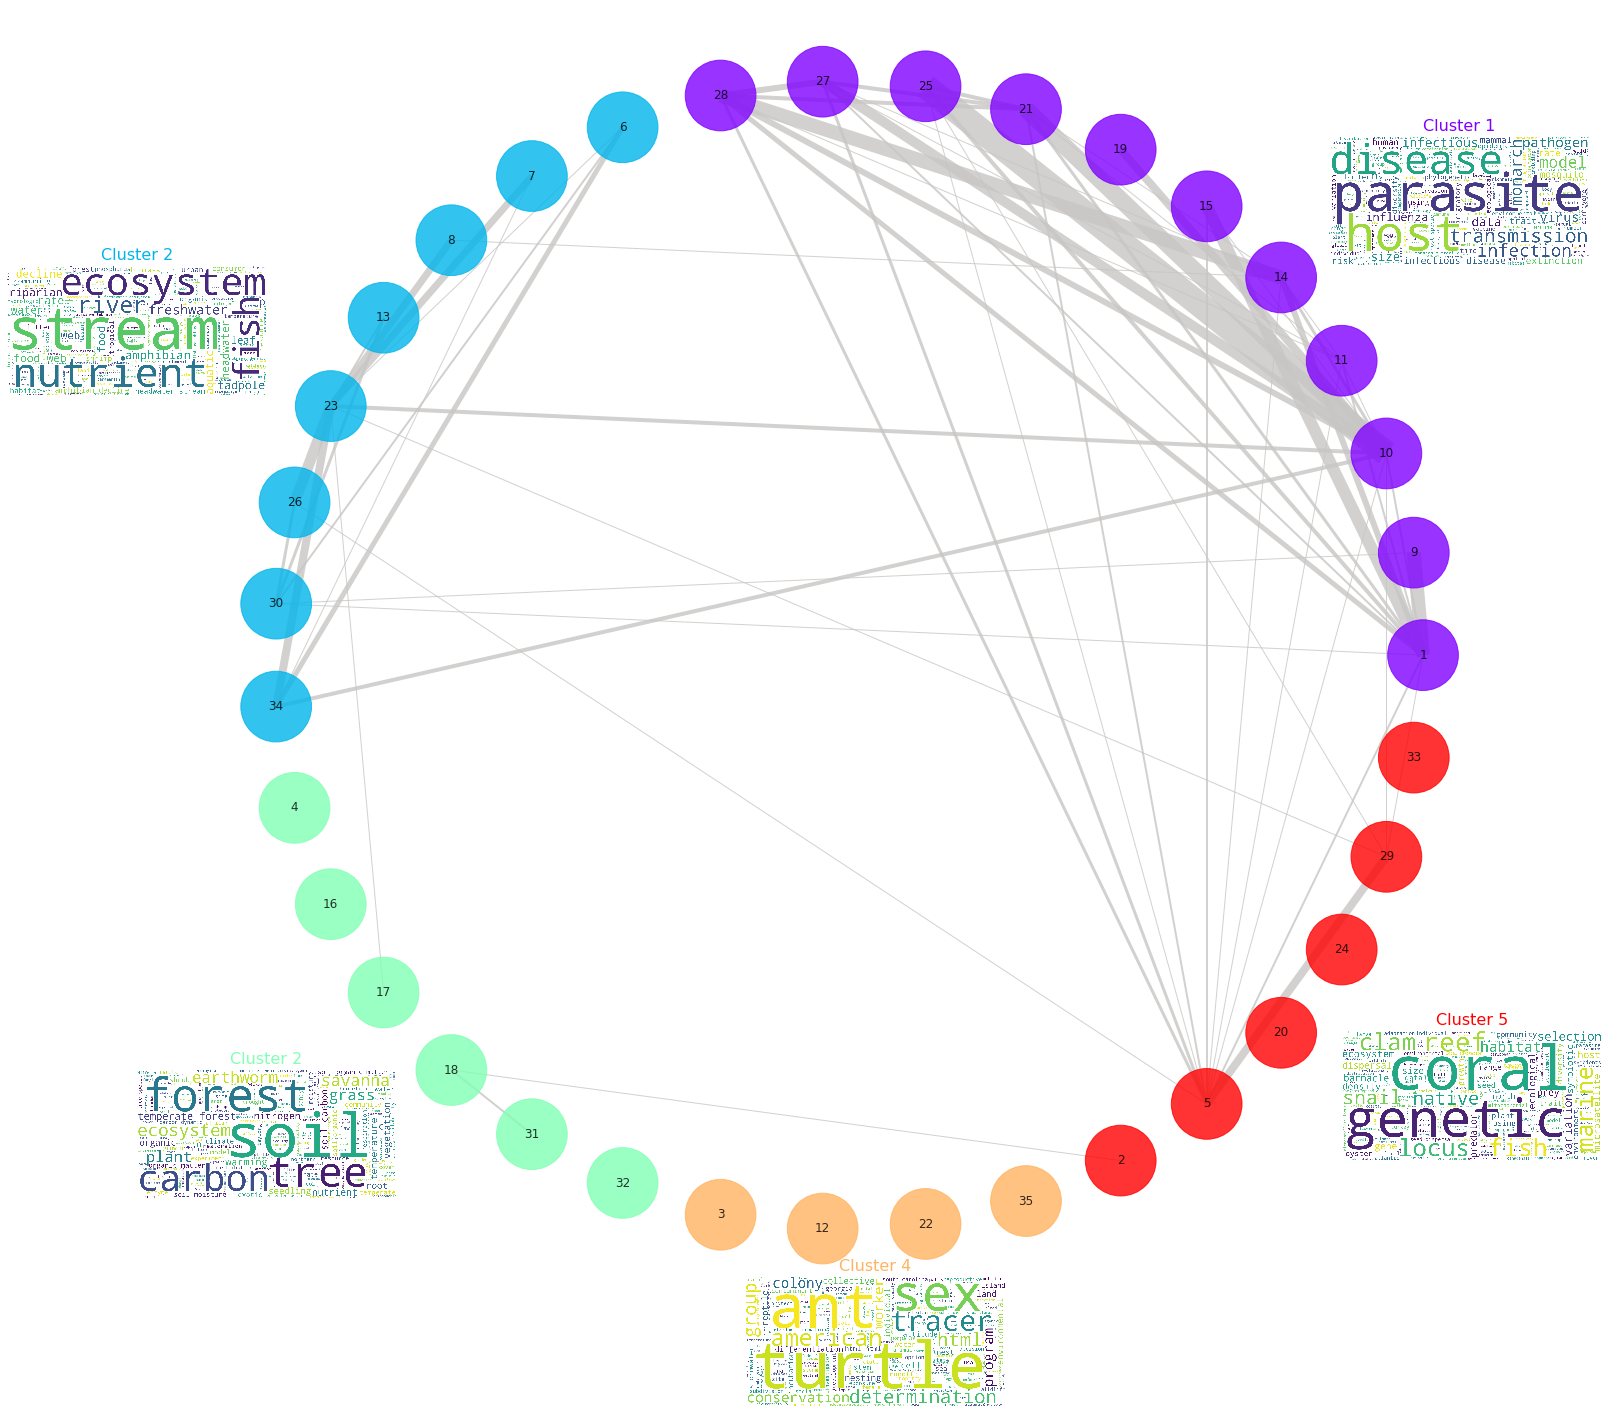

In [92]:
fig=plt.figure(figsize=(18,18))
pos = nx.circular_layout(G_sorted)

edges = G_sorted.edges()
weights = [G_sorted[u][v]['weight'] for u,v in edges]


colors_list=[]
for node in list(G_sorted.nodes):
    cluster_number=faculty_to_cluster_dic[node]
    colors_list.append(cluster_colors[cluster_number])

labels={name:list(name.split())[-1] for name in adj_matrix_sorted.index}



nx.draw(G_sorted,
        pos,
        node_color=colors_list,
        alpha=0.8,
        font_size=12,
        edges=edges, 
        edge_color='#C7C6C4',
        width=weights,
        labels=labels,
        with_labels=True,
        font_color='black',
        node_size=5000)



newax = fig.add_axes([0.87, 0.7, 0.2, 0.2], anchor='N', zorder=-1)
newax.imshow(wordcloud_dic[1])
newax.axis('off')
newax.set_title('Cluster 1' ,color=cmap[0][:3],fontsize=16)


newax = fig.add_axes([0.88, 0.01, 0.2, 0.2], anchor='N', zorder=-1)
newax.imshow(wordcloud_dic[5])
newax.axis('off')
newax.set_title('Cluster 5' ,color=cmap[4][:3],fontsize=16)



newax = fig.add_axes([0.42, -0.18, 0.2, 0.2], anchor='N', zorder=-1)
newax.imshow(wordcloud_dic[4])
newax.axis('off')
newax.set_title('Cluster 4' ,color=cmap[3][:3],fontsize=16)


newax = fig.add_axes([-0.05, -0.02, 0.2, 0.2], anchor='N', zorder=-1)
newax.imshow(wordcloud_dic[3])
newax.axis('off')
newax.set_title('Cluster 2' ,color=cmap[2][:3],fontsize=16)



newax = fig.add_axes([-0.15, 0.6, 0.2, 0.2], anchor='N', zorder=-1)
newax.imshow(wordcloud_dic[2])
newax.axis('off')
newax.set_title('Cluster 2' ,color=cmap[1][:3],fontsize=16)



plt.show()

## With PCA mapping (two PCs)

In [93]:
normalized_tfidf=tfidf_df-tfidf_df.mean()
normalized_tfidf=normalized_tfidf.astype('float64')
pca=PCA(n_components=2)
tfidf_2pcs=pca.fit_transform(normalized_tfidf)

In [94]:
pca.explained_variance_

array([0.10276126, 0.06399119])

In [95]:
pos_dic={tfidf_df.index[i]:tfidf_2pcs[i] for i in range(tfidf_2pcs.shape[0])}

/home/arashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


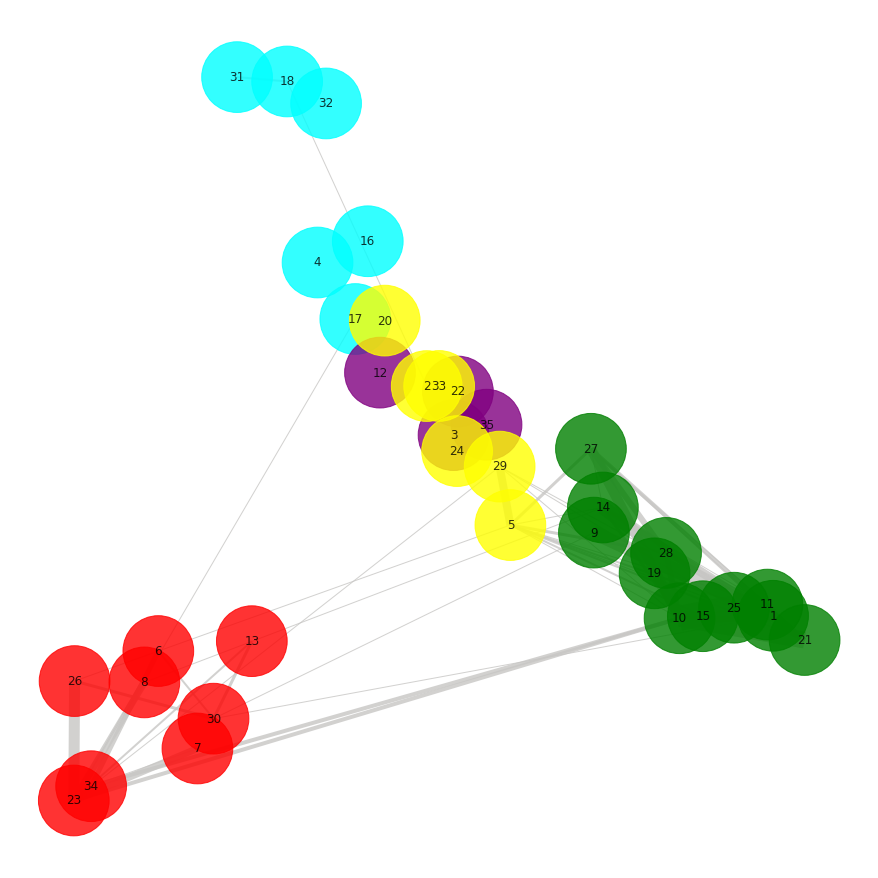

In [101]:
fig=plt.figure(figsize=(12,12))



edges = G_sorted.edges()
weights = [G_sorted[u][v]['weight'] for u,v in edges]

cluster_colors={1:'green',2:'red',3:'cyan',4:'purple',5:'yellow',}
colors_list=[]
for node in list(G_sorted.nodes):
    cluster_number=faculty_to_cluster_dic[node]
    colors_list.append(cluster_colors[cluster_number])

labels={name:list(name.split())[-1] for name in adj_matrix_sorted.index}

nx.draw(G_sorted,
        pos=pos_dic,
        node_color=colors_list,
        alpha=0.8,
        font_size=12,
        edges=edges, 
        edge_color='#C7C6C4',
        width=weights,
        labels=labels,
        with_labels=True,
        font_color='black',
        node_size=5000)

# With mMDS mapping

In [98]:
mds=MDS(n_components=2)
tfidf_MDS_2comp=mds.fit_transform(normalized_tfidf)

In [99]:
MDS_pos_dic={tfidf_df.index[i]:tfidf_MDS_2comp[i] for i in range(tfidf_MDS_2comp.shape[0])}

/home/arashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


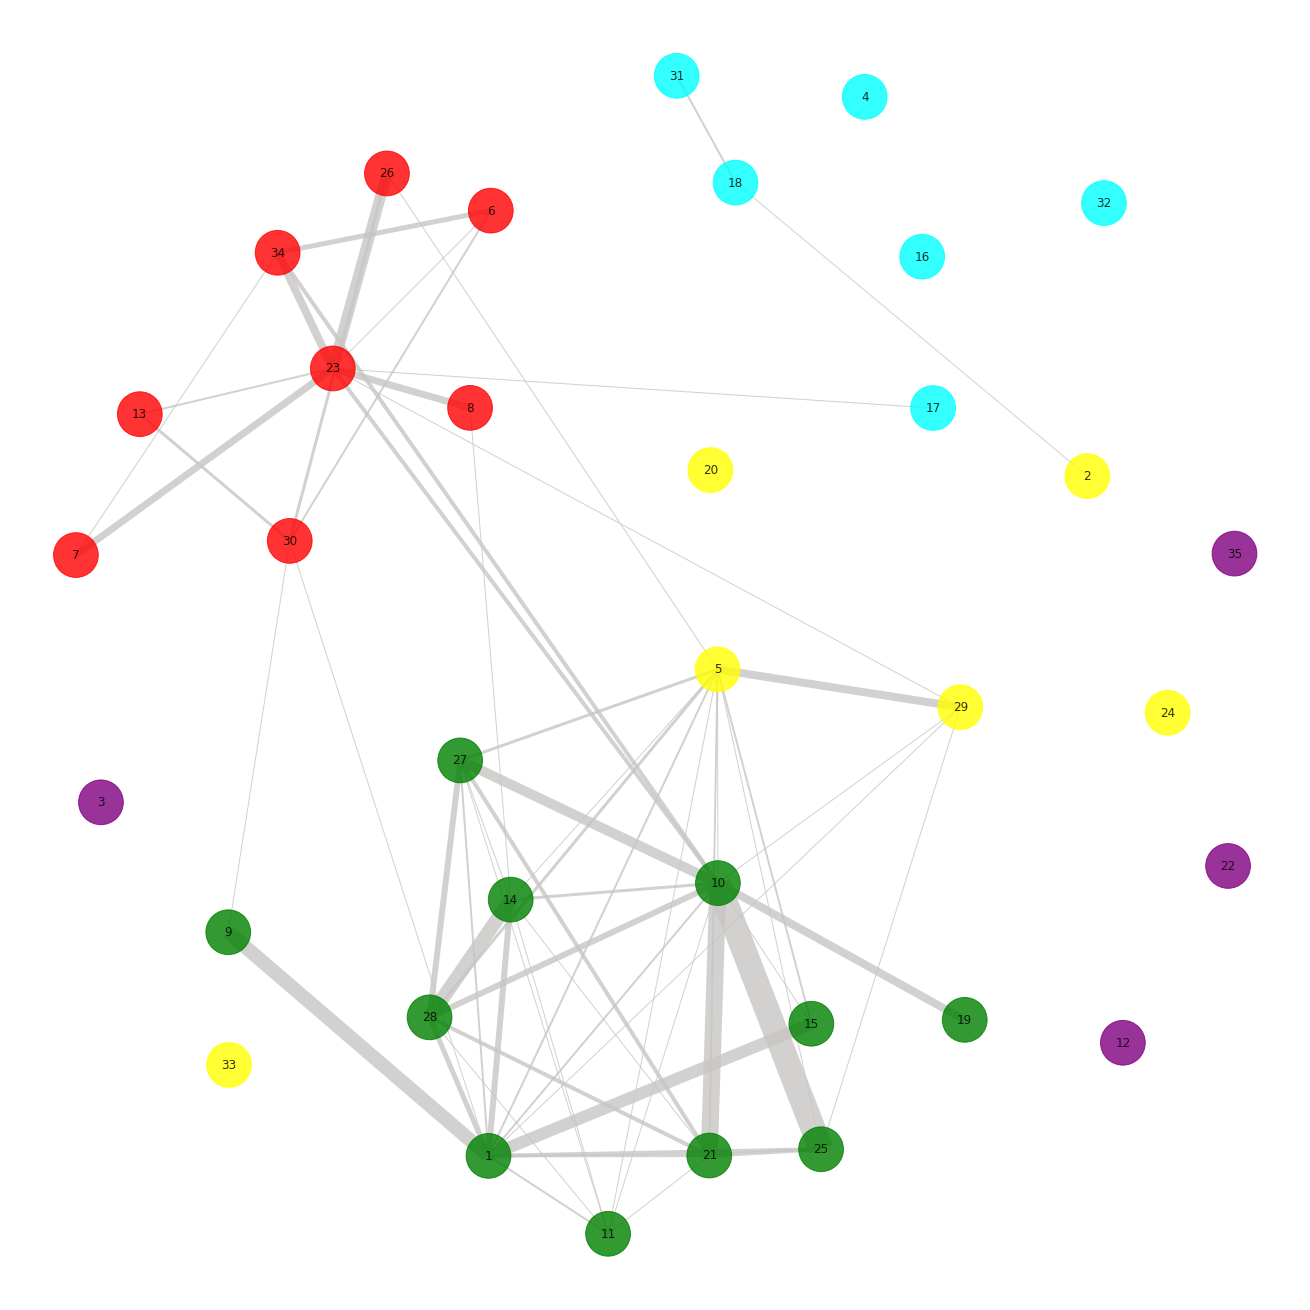

In [100]:
fig=plt.figure(figsize=(18,18))


edges = G_sorted.edges()
weights = [G_sorted[u][v]['weight'] for u,v in edges]

cluster_colors={1:'green',2:'red',3:'cyan',4:'purple',5:'yellow',}
colors_list=[]
for node in list(G_sorted.nodes):
    cluster_number=faculty_to_cluster_dic[node]
    colors_list.append(cluster_colors[cluster_number])

labels={name:list(name.split())[-1] for name in adj_matrix_sorted.index}

nx.draw(G_sorted,
        pos=MDS_pos_dic,
        node_color=colors_list,
        alpha=0.8,
        font_size=12,
        edges=edges, 
        edge_color='#C7C6C4',
        width=weights,
        labels=labels,
        with_labels=True,
        font_color='black',
        node_size=2000)